In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn

In [3]:
cd ~/workspace/theislab/mubind/docs/notebooks/scatac

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac


In [4]:
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [5]:
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

# motifs loaded 2179


286

In [6]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [7]:
# len(reduces_groups)

In [8]:
# reduced_groups = mb.tl.reduce_filters([p.to_numpy() for p in pwms[:10]], thr_group=0.03, plot=False)

In [9]:
# reduced_groups = reduced_groups[:4]
# reduced_groups = reduced_groups[:1]

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

Using device: cuda:0


In [11]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [12]:
import scanpy as sc

In [13]:
# atac_path = '../../../annotations/scatac/ancreas_multiome_2022_processed_sample_c16918_p50000.h5ad'
all_path = '../../../annotations/scatac/pancreas_multiome_2022_processed.h5ad'
atac_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_atac.h5ad'
rna_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_rna.h5ad'
if not os.path.exists(atac_path):
    print('preparing atac...')
    adata = sc.read_h5ad(all_path)
    print(adata.shape)
    atac = adata[:,adata.var.modality == 'ATAC'].copy()
    print(atac.shape)
    atac.write(atac_path, compression='lzf')
if not os.path.exists(rna_path):
    print('preparing rna...')
    adata = sc.read_h5ad(all_path)
    print(adata.shape)
    rna = adata[:,adata.var.modality == 'GEX'].copy()
    print(rna.shape)
    rna.write(rna_path, compression='lzf')

In [14]:
atac = sc.read_h5ad(atac_path)

(array([  782.,   732.,   754.,   730.,   746.,   679.,   702.,   737.,
          666.,   657.,   638.,   621.,   587.,   636.,   639.,   640.,
          699.,   756.,   778.,   850.,   944.,  1070.,  1290.,  1566.,
         1888.,  2262.,  2990.,  3753.,  5173.,  6968., 10067., 15120.,
        26728., 62772., 71639.]),
 array([0.        , 0.01427051, 0.02854103, 0.04281154, 0.05708206,
        0.07135257, 0.08562309, 0.0998936 , 0.11416412, 0.12843463,
        0.14270515, 0.15697566, 0.17124618, 0.18551669, 0.19978721,
        0.21405772, 0.22832824, 0.24259875, 0.25686927, 0.27113978,
        0.2854103 , 0.29968081, 0.31395133, 0.32822184, 0.34249236,
        0.35676287, 0.37103339, 0.3853039 , 0.39957442, 0.41384493,
        0.42811545, 0.44238596, 0.45665648, 0.47092699, 0.48519751,
        0.49946802]),
 <BarContainer object of 35 artists>)

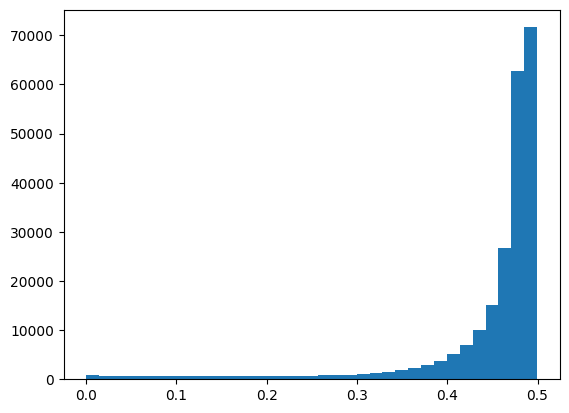

In [15]:
acc = (atac.X != 0).sum(axis=0) / atac.shape[0]
acc_score = abs(.5 - acc)
atac.var['acc_score'] = acc_score.A.T
atac.var['acc_score_rank'] = atac.var['acc_score'].rank(ascending=False)
plt.hist(atac.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [16]:
n_sample_cells = 600
n_sample_peaks = int(n_sample_cells * 1.5)
obs_sample = pd.Series(atac.obs_names).sample(n_sample_cells)
var_sample = pd.Series(atac.var_names).sample(n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = atac[atac.obs_names.isin(obs_sample),atac.var_names.isin(var_sample)].copy()
ad.shape

(600, 900)

In [17]:
ad.obs['celltype'].value_counts()

Ductal               130
Ngn3 high            128
Imm. Acinar           63
Fev+                  52
Prlf. Ductal          52
Mat. Acinar           39
Ngn3 low              37
Fev+ Beta             30
Beta                  22
Fev+ Alpha            12
Alpha                 10
Epsilon                8
Fev+ Delta             7
Delta                  5
Eps. progenitors       3
Ngn3 high cycling      2
Name: celltype, dtype: int64

In [18]:
ad.shape

(600, 900)

/home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


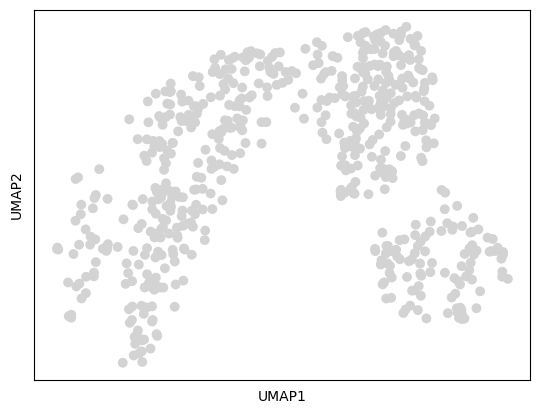

In [19]:
sc.pl.umap(ad)

In [20]:
ad.var

,modality,acc_score,acc_score_rank
1-14635600-14636529,ATAC,0.488947,39818.0
1-19737744-19738653,ATAC,0.492079,13489.0
1-24587116-24587704,ATAC,0.419494,190803.0
1-33964332-33965203,ATAC,0.440714,177648.5
1-36746257-36747147,ATAC,0.469086,138928.5
...,...,...,...
X-56845013-56845802,ATAC,0.489420,35436.0
X-94506076-94506893,ATAC,0.493557,5959.5
X-99966416-99967349,ATAC,0.488415,44735.0
X-167161076-167161985,ATAC,0.483863,81051.0


In [21]:
ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

In [22]:
extend = 50

ad.var['chr'].value_counts()

chr1     64
chr2     64
chr5     59
chr11    59
chr9     55
chr4     54
chr8     54
chr7     53
chr10    52
chr3     47
chr15    47
chr17    46
chr13    44
chr14    41
chr6     40
chr12    38
chr16    27
chr18    26
chr19    23
chrX      7
Name: chr, dtype: int64

In [23]:
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [24]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa')
keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

convert bed to fasta
/tmp/tmpzocy6olr
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmpzocy6olr -fo /tmp/tmp6nb6k28o
get fasta
/tmp/tmp6nb6k28o


900

In [25]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [26]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [27]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [28]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(900, 601)

In [29]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [30]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [31]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [32]:
next_data_sel

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,var
seq,,,,,,,,,,,,,,,,,,,,,
CACAGGGATAACTGGCTTGTGGCGGCCAAGCGTTCATAGCGACGTCGCTTTTTGATCCTTCGATGTCGGCTCTTCCTATCATTGTGAAGCAGAATTCACC,2.0,12.0,3.0,6.0,0.0,1.0,1.0,0.0,0.0,2.0,...,0.0,1.0,1.0,2.0,1.0,3.0,0.0,5.0,1.0,5.613478
CTTCCCGCCTCCCGCGTCCGCCAAGGCGCCTGGGCAGGCCGCGCCTAGACCACGCCCCCAAGAGGTGGGGCGGTTTTCCAGGGGGCGGAGCCAGAGTCGG,3.0,0.0,1.0,2.0,2.0,1.0,4.0,2.0,1.0,0.0,...,0.0,3.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,1.571508
AGCACGCGCGCGCCACCGCCGTGCCCGCGCCTGCGCGAGCGCGCGCGCGAGCCTCCCGGGCTCTCCTCCCCGCTGCCCGGCCCCGCCCACCCTCTAGGGC,0.0,1.0,0.0,3.0,3.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,2.0,0.0,2.0,3.0,1.0,1.529146
TAAGTCCTTACATGGACTACATAACCCAGCATCCACCGCGGCAGATTGGTTTCCGGGTCAAGAGGTCCGCTCTGGGTGCATCACCATGGAAGCGCTCGGT,1.0,1.0,1.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,3.0,1.0,0.0,1.0,1.379087
CTGCGCCTTGAGAGGGTGGGGCCTAACAGTCCGCTGCCTCCGACCGCTGCTGACGCCCGTGGTGGGGCGAGGCCCGCGCCTGGATAGGGTGGGGCCTCCC,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,3.0,0.0,1.0,1.0,0.0,1.296937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACTTTGCTTTTGCTCCCGTGCCCTGCCACTGTCAAAGTGTTTTCGGCTCAGAATCAGTCTGACTCTAGTTATAACACATGTCACTGTGTCCTTGGATCGA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001667
CTCAATTGAGAAAATGCCTCTATCAGAGTGCCTGTGGCAAGTATGTAGGGCATTTTCTTGATTAATGATCAACGTGGGGGAGCCCAGCTCACTGGTTGAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001667
TCTCCCATTCTTTCTGTAAATGTTAACTAATTCAATTCAATGCAAACCGGCTCTGCTGGACTGTAAATTATTCATAAATGTGCTATGATTTTTTGCATAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001667


In [33]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [34]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(900, 600)

In [35]:
ad = ad[:,~zero_counts].copy()


In [36]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(540000, 3)
600
0      900
137    900
127    900
128    900
129    900
      ... 
69     900
70     900
71     900
72     900
199    900
Name: batch, Length: 200, dtype: int64


,0,1,batch
seq,,,
CACAGGGATAACTGGCTTGTGGCGGCCAAGCGTTCATAGCGACGTCGCTTTTTGATCCTTCGATGTCGGCTCTTCCTATCATTGTGAAGCAGAATTCACC,1.0,2.0,0
CTTCCCGCCTCCCGCGTCCGCCAAGGCGCCTGGGCAGGCCGCGCCTAGACCACGCCCCCAAGAGGTGGGGCGGTTTTCCAGGGGGCGGAGCCAGAGTCGG,1.0,3.0,0
AGCACGCGCGCGCCACCGCCGTGCCCGCGCCTGCGCGAGCGCGCGCGCGAGCCTCCCGGGCTCTCCTCCCCGCTGCCCGGCCCCGCCCACCCTCTAGGGC,1.0,0.0,0
TAAGTCCTTACATGGACTACATAACCCAGCATCCACCGCGGCAGATTGGTTTCCGGGTCAAGAGGTCCGCTCTGGGTGCATCACCATGGAAGCGCTCGGT,1.0,1.0,0
CTGCGCCTTGAGAGGGTGGGGCCTAACAGTCCGCTGCCTCCGACCGCTGCTGACGCCCGTGGTGGGGCGAGGCCCGCGCCTGGATAGGGTGGGGCCTCCC,1.0,0.0,0


### Simple motif enrichment

In [37]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [38]:
import ushuffle

fg = df.index
bg = []

for i, s in enumerate(fg):
    # print(i, s)
    bg.append(ushuffle.shuffle(str.encode(s), 2))



In [39]:
for a, b in zip(fg, bg):
    # print(len(a[1]), len(b))
    assert len(a) == len(b)

In [40]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [41]:
reduced_groups = pwms

In [42]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)


In [43]:
df_neg = df.copy()
df_neg.index = bg
df_neg.index = df_neg.index.astype(str)

dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=1024, shuffle=True)


In [44]:
import torch.optim as topti
import warnings
warnings.filterwarnings("ignore")
criterion = mb.tl.PoissonLoss()

w = [r.shape[1] for r in reduced_groups]
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=False,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None).cuda()

# initialize the reduce kernels
for i, mono_best in enumerate(reduced_groups):
    if mono_best.shape[-1] == 0:
        continue
    mono_best = mono_best.to_numpy()
    new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
    model.binding_modes.conv_mono[i + 1].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
model = model.to(device)


In [45]:
# calculate scores per binding mode, using the binding layer
# unsqueeze mono after preparing di and unsqueezing mono
mono = torch.tensor(train.dataset.mononuc, device=device)
mono_rev = mono
mono_rev = torch.unsqueeze(mono_rev, 1)
mono = torch.unsqueeze(mono, 1)
mono.shape, mono_rev.shape

bm_pred = model.binding_modes(mono, mono_rev)
bm_pred = bm_pred.detach().cpu().numpy()[:,1:]

# 01 normalize
for ci in range(bm_pred.shape[1]):
    v = bm_pred[:, ci]
    vmin, vmax = v.min(), v.max()
    print(ci, vmin, vmax)
    bm_pred[:, ci] = (v - vmin) / (vmax - vmin)

scores_fg = {}

for ci in range(bm_pred.shape[1]):
    scores_fg[ci] = bm_pred[:, ci]

0 917.86475 9274.847
1 5544.2617 60470.78
2 1711.6682 6946.268
3 4405.836 25016.395
4 2001.0697 24003.594
5 2575.2178 20759.027
6 7776.123 97147.22
7 13191.042 431652.44
8 4464.192 19452.215
9 2894.0908 12268.361
10 5886.3423 29331.758
11 405.82446 15467.896
12 2734.8154 5998.3716
13 7394.141 53095.527
14 2766.3079 34153.76
15 1698.1023 31171.55
16 4293.953 222929.44
17 1413.9412 8330.309
18 8558.127 168652.53
19 6673.9404 93646.57
20 1726.324 12788.917
21 3913.8958 12651.693
22 8377.497 77764.67
23 1941.4215 11843.497
24 3614.67 13503.697
25 1978.6753 61356.066
26 3551.438 125029.555
27 1446.8906 10151.121
28 6539.7524 44493.977
29 1693.5349 8928.136
30 2590.0203 36251.68
31 4793.2285 19236.072
32 1420.8469 10329.863
33 2247.1838 77411.89
34 2087.7183 7178.8926
35 2397.0288 87112.56
36 2533.6914 16857.576
37 2611.4062 61199.074
38 2496.6465 142808.44
39 1287.6274 3255428.0
40 2283.4739 29870.902
41 980.3187 7889.209
42 3032.804 85255.92
43 6123.284 376378.03
44 6038.0654 447805.88
45 

In [46]:
# calculate scores per binding mode, using the binding layer
# unsqueeze mono after preparing di and unsqueezing mono
mono = torch.tensor(train_neg.dataset.mononuc, device=device)
mono_rev = mono
mono_rev = torch.unsqueeze(mono_rev, 1)
mono = torch.unsqueeze(mono, 1)

bm_pred = model.binding_modes(mono, mono_rev)
bm_pred = bm_pred.detach().cpu().numpy()[:,1:]


In [47]:
# calculate scores per binding mode, using the binding layer
# unsqueeze mono after preparing di and unsqueezing mono
mono = torch.tensor(train_neg.dataset.mononuc, device=device)
mono_rev = mono
mono_rev = torch.unsqueeze(mono_rev, 1)
mono = torch.unsqueeze(mono, 1)

bm_pred = model.binding_modes(mono, mono_rev)
bm_pred = bm_pred.detach().cpu().numpy()[:,1:]

# 01 normalize
for ci in range(bm_pred.shape[1]):
    v = bm_pred[:, ci]
    vmin, vmax = v.min(), v.max()
    print(ci, vmin, vmax)
    bm_pred[:, ci] = (v - vmin) / (vmax - vmin)

scores_bg = {}

for ci in range(bm_pred.shape[1]):
    scores_bg[ci] = bm_pred[:, ci]

0 887.3449 5804.5137
1 5754.4434 62049.867
2 1884.8848 5988.918
3 4045.3552 21555.701
4 2149.3296 23748.035
5 2627.7107 17916.564
6 7007.144 66039.55
7 11737.285 387631.25
8 4684.071 18274.652
9 3362.6143 13817.74
10 6555.09 29892.988
11 447.14545 13595.852
12 2805.6025 6762.25
13 8152.5796 44103.168
14 2955.1455 28269.309
15 1679.6917 27322.344
16 5560.0957 133183.17
17 1514.4241 7753.6416
18 9841.286 99885.47
19 7270.581 88636.32
20 1878.1692 12096.841
21 4341.213 12949.172
22 9459.868 69543.984
23 1937.3442 9764.916
24 3798.8174 16113.982
25 1900.9741 44507.29
26 4601.6924 159180.6
27 1342.0632 10985.693
28 6600.907 36912.906
29 1872.4294 7273.408
30 2998.2207 22254.207
31 4594.6816 17498.805
32 1276.5432 9189.284
33 2503.1963 37410.105
34 1953.1201 7735.292
35 2395.1055 86160.28
36 2785.844 26208.547
37 2940.9607 41117.773
38 2344.7905 120511.33
39 1031.9524 4108415.5
40 2230.19 23214.71
41 1063.3889 7556.196
42 2782.1433 110592.336
43 6684.0996 247272.28
44 6031.7344 185652.17
45 

In [48]:
calc_pwm_scores = False
if calc_pwm_scores:
    from numba import jit

    scores_fg = {}
    scores_bg = {}

    def get_scores(entries, kmers):
        scores = []
        # print(entries[0])
        for s in entries:
            # print(h, s)
            s = str(s)
            base_for = "ACGT"
            base_rev = "TGCA"
            comp_tab = str.maketrans(base_for, base_rev)
            s_rev = s.translate(comp_tab)[::-1]

            seq_score = 0
            for k in kmers:
                if k in s or k in s_rev:
                    seq_score = 1
                    break
            scores.append(seq_score)
        return scores

    @jit
    def get_scores(pwm_vals, nts, cols):
        return np.sum(pwm_vals[nts, cols])

    def get_scores_pwm(entries, pwm):
        scores = []
        pwm_vals = pwm.values
        cols = pwm.columns
        np.array(cols)

        for si, s in enumerate(entries):
            # print(si) # print(h, s)
            s = str(s)
            base_for = "ACGT"
            base_rev = "TGCA"
            comp_tab = str.maketrans(base_for, base_rev)
            s_rev = s.translate(comp_tab)[::-1]
            entry_scores = []
            for i in range(len(s) - pwm.shape[1] + 1):
                fwd, rev = [sub[i:i + pwm.shape[1]] for sub in [s, s_rev]]
                # print(len(fwd), len(rev), pwm.shape)
                # score_fwd, score_rev = [np.sum([pwm[ci][nti] for ci, nti in zip(pwm, sub)]) for sub in [fwd, rev]]
                nts = np.array(['ACGT'.find(nt) for nt in fwd])
                score_fwd = get_scores(pwm_vals, nts, cols) # np.sum(pwm_vals[nts, cols])
                nts = np.array(['ACGT'.find(nt) for nt in rev])
                score_rev = get_scores(pwm_vals, nts, cols) # np.sum(pwm_vals[nts, cols])
                next_score = score_fwd + score_rev
                entry_scores.append(score_fwd)
                entry_scores.append(score_rev)

            scores.append(max(entry_scores))
        return scores


    for pi, pwm in enumerate(pwms):
        # print(pi)
        pos = get_scores_pwm(fg, pwm)

        # print(mi, m, pos)
        scores_fg[pi] = pos
        neg = get_scores_pwm(bg, pwm)
        scores_bg[pi] = neg
        # print(len(fg), len(bg))
        # if pi % 5 == 0:
        print(pi, np.mean(pos), np.mean(neg))


In [49]:
import sklearn
import numpy as np
import scipy
from statsmodels.stats.multitest import fdrcorrection

res = []
for pi, pwm in enumerate(pwms):
    pos, neg = scores_fg[pi], scores_bg[pi]

    assert len(pos) > 0 and len(neg) > 0
    y_true = np.concatenate([np.repeat(1, len(pos)), np.repeat(0, len(neg))])
    y_score  = np.concatenate([pos, neg])

    roc_auc = sklearn.metrics.roc_auc_score(y_true, y_score)
    pval = scipy.stats.ranksums(pos, neg)[1]
    res.append([pi, roc_auc, np.mean(pos), np.mean(neg), pval])
    # print(m, roc_auc)

res = pd.DataFrame(res, columns=['pwm_id', 'auroc', 'mean_fg', 'mean_bg', 'p_value'])

res['p_adj'] = fdrcorrection(res['p_value'])[1]
res = res.sort_values(['auroc', 'p_value'], ascending=[False, True])
res.head()


,pwm_id,auroc,mean_fg,mean_bg,p_value,p_adj
196,196,0.897279,0.184967,0.065495,2.935052e-187,1.199178e-185
142,142,0.881128,0.312728,0.169684,1.655752e-172,3.946210e-171
36,36,0.867953,0.362405,0.203522,6.318219e-161,1.129382e-159
244,244,0.867740,0.154523,0.067062,9.660353e-161,1.625212e-159
274,274,0.859865,0.092888,0.032174,5.113126e-154,7.311770e-153


In [50]:
scores_per_cell_n_module = {}
for pi, pwm in enumerate(pwms):
    pos, neg = np.array(scores_fg[pi]), np.array(scores_bg[pi])
    next_scores = []
    for c in df:
        labels = df[c].values
        cell_is_acc = (labels != 0)
        a = pos[cell_is_acc].mean() - neg[cell_is_acc].mean()
        b = pos[~cell_is_acc].mean() - neg[~cell_is_acc].mean()
        # # print(c, m, a - b)
        # a, b = pos[cell_is_acc], pos[~cell_is_acc]
        # a = a.mean() if len(a) != 0 else 0
        # b = b.mean() if len(b) != 0 else 0
        next_scores.append(a - b)
    scores_per_cell_n_module[pi] = next_scores

In [51]:
scores_kmers = pd.DataFrame(scores_per_cell_n_module)

In [52]:
import seaborn as sns

In [53]:
# scores_kmers
# sns.clustermap(scores_kmers, cmap='RdBu_r', yticklabels=False, xticklabels=False)

In [54]:
scores_kmers.index = ad.obs_names

In [55]:
ad.obsm['kmers'] = scores_kmers

In [56]:
for c in scores_kmers:
    ad.obs[c] = ad.obsm['kmers'][c]

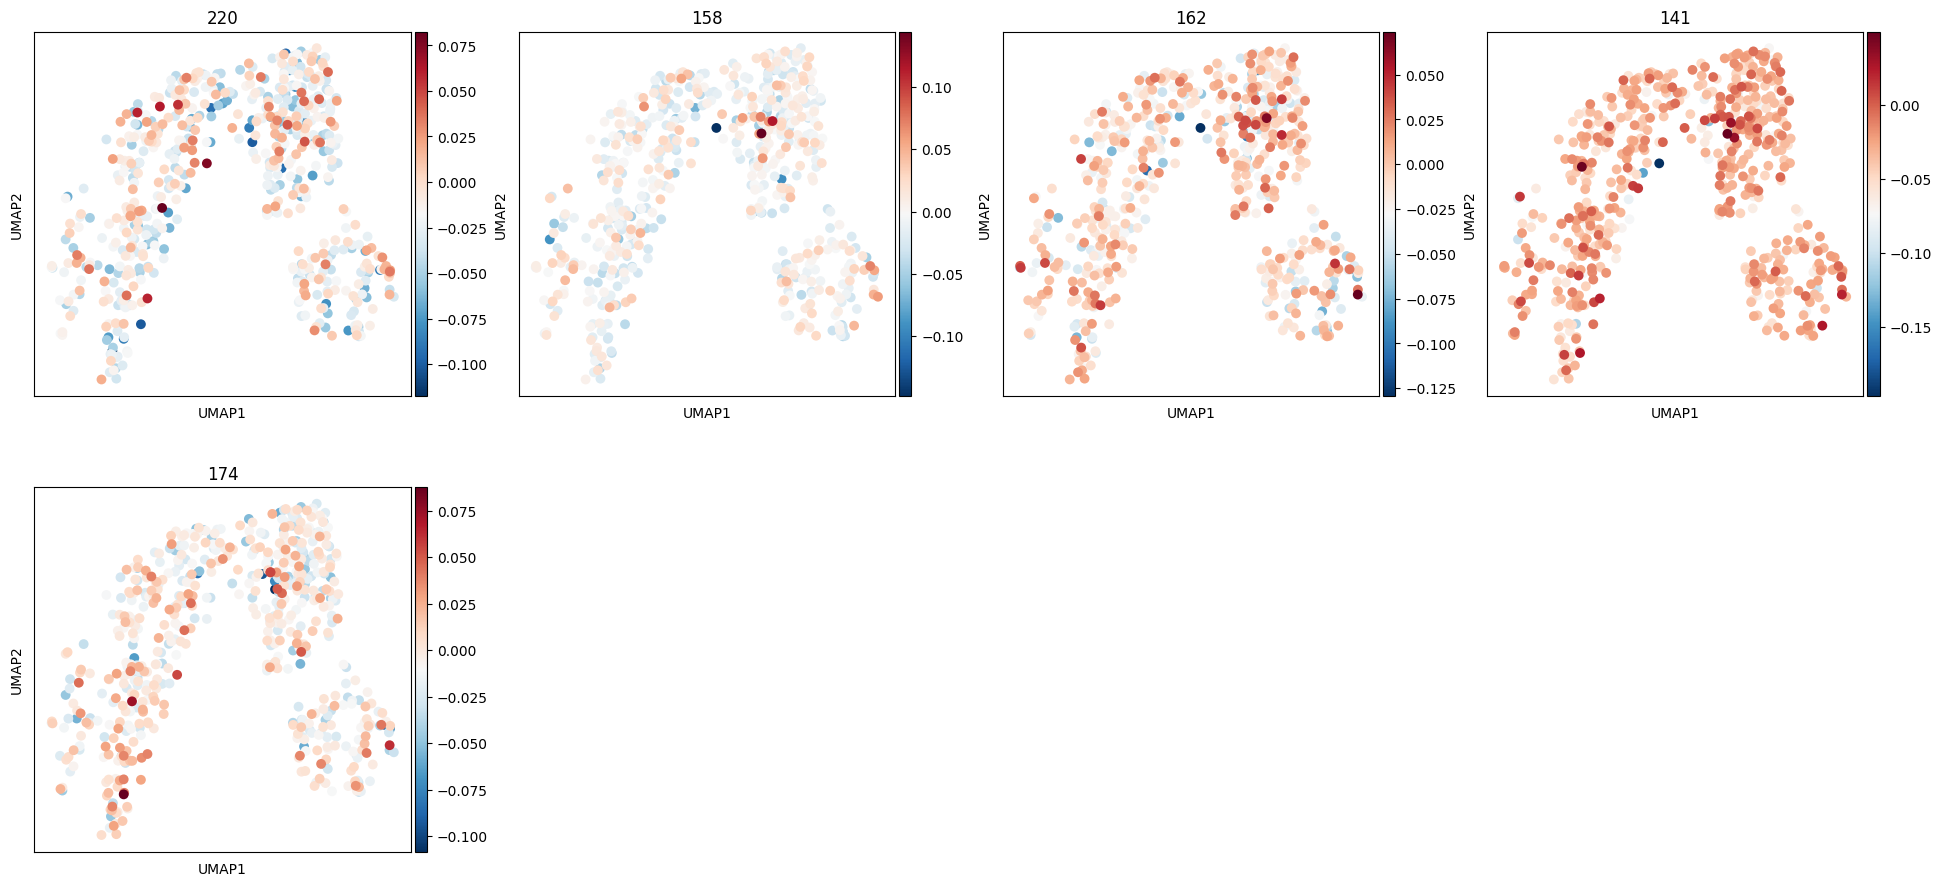

In [57]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 5
sc.pl.umap(ad, color=scores_kmers.var(axis=0).sort_values(ascending=False).index[:5], cmap='RdBu_r')

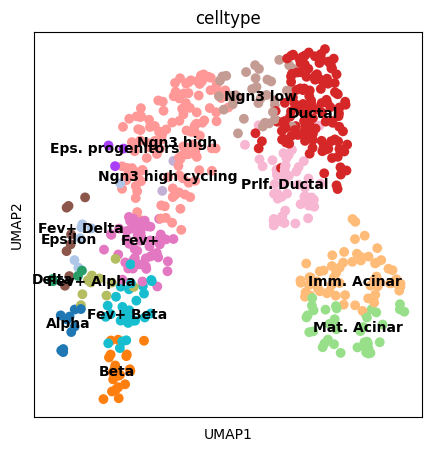

In [58]:
sc.pl.umap(ad, color='celltype', legend_loc='on data')

In [59]:
diff_by_celltype = {}
for c in set(ad.obs['celltype']):
    ad1 = ad[ad.obs['celltype'] == c,:]
    ad2 = ad[ad.obs['celltype'] != c,:]
    s1 = ad1.obs.mean()[ad1.obsm['kmers'].columns]
    s2 = ad2.obs.mean()[ad2.obsm['kmers'].columns]
    diff_by_celltype[c] = s1 - s2
diff_by_celltype = pd.DataFrame(diff_by_celltype)

In [60]:
sel_idx = set()
for c in diff_by_celltype:
    idx = np.argmax(diff_by_celltype[c])
    print(c, idx)
    sel_idx.add(idx)

Eps. progenitors 274
Ductal 146
Fev+ Beta 179
Ngn3 high cycling 174
Delta 16
Imm. Acinar 16
Epsilon 74
Fev+ Alpha 36
Mat. Acinar 129
Fev+ Delta 174
Ngn3 low 245
Ngn3 high 34
Fev+ 58
Beta 276
Alpha 223
Prlf. Ductal 128


In [61]:
sel_idx = sorted(list(sel_idx))
sel_idx

[16, 34, 36, 58, 74, 128, 129, 146, 174, 179, 223, 245, 274, 276]

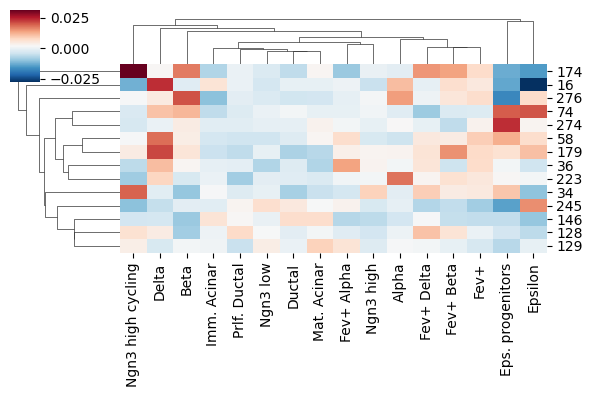

In [62]:
sns.clustermap(diff_by_celltype.reindex(sel_idx), cmap='RdBu_r', figsize=[6, 4])

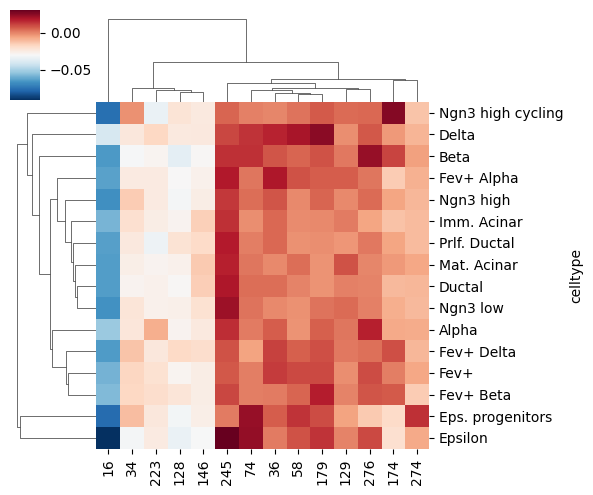

In [63]:
sns.clustermap(ad.obs.groupby('celltype').mean()[sel_idx], cmap='RdBu_r', figsize=[6, 5])

### This is the relatedness graph and used for dynamics filters learning

In [64]:
# sum(adata.obs_names.isin(df.index)

In [65]:
ad.shape, (~zero_counts).sum()

((600, 900), 900)

In [66]:
if ad.shape[1] != (~zero_counts).sum():
    ad = ad[:,~zero_counts].copy()

In [67]:
rel = ad.uns['neighbors']['connectivities'].A
# rel[:n_cells,:n_cells].sum()
rel.shape
rel.sum()

187.14417

In [68]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))

n_batch = len(set(dataset.batch))
n_batch

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)


In [69]:
# log_etas = torch.tensor(np.log(df.sum(axis=0) / df.sum().sum())).reshape(1, n_batch).to(device)
# log_etas

In [70]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [71]:
len(reduced_groups)
selected_groups = [r for i, r in enumerate(reduced_groups) if i in sel_idx]
len(selected_groups)

14

In [72]:
sel_idx

[16, 34, 36, 58, 74, 128, 129, 146, 174, 179, 223, 245, 274, 276]

In [73]:
# n_kernels = len(selected_groups)
n_kernels = len(pwms)
# n_kernels = 8

## The parameter log_dynamic defines whether a kNN-graph will be used

True
12
0 out of 288...


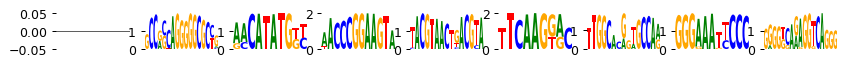

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 150 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
Epoch: 11, Loss: 267.202209, R2: 0.25,  best epoch: 9,  secs per epoch: 0.787 s,  secs epoch*1k trials: 0.874s curr time: 2023-05-16 11:38:37.537510
Epoch: 21, Loss: 261.696045, R2: 0.26,  best epoch: 19,  secs per epoch: 0.653 s,  secs epoch*1k trials: 0.725s curr time: 2023-05-16 11:38:42.730442
Epoch: 31, Loss: 255.577057, R2: 0.27,  best epoch: 29,  secs per epoch: 0.638 s,  secs epoch*1k trials: 0.709s curr time: 2023-05-16 11:38:48.824647
Epoch: 41, Loss: 248.966934, R2: 0.28,  best epoch: 39,  secs per epoch: 0.675 s,  secs epoch*1k trials: 0.749s curr time: 2023-05-16 11:38:56.654062
Epoch: 51, Loss: 242.058060, R2: 0.28,  best epoch: 49,  secs per epoch: 0.658 s,  secs epoch*1k trials: 0.731s curr time

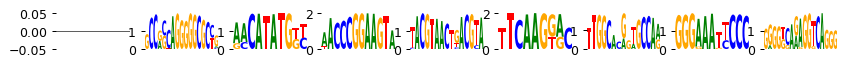

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 150 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
Epoch: 11, Loss: 269.561676, R2: 0.24,  best epoch: 9,  secs per epoch: 0.870 s,  secs epoch*1k trials: 0.967s curr time: 2023-05-16 11:43:34.832125
Epoch: 21, Loss: 262.663727, R2: 0.25,  best epoch: 19,  secs per epoch: 0.967 s,  secs epoch*1k trials: 1.074s curr time: 2023-05-16 11:43:45.459082
Epoch: 31, Loss: 255.932312, R2: 0.26,  best epoch: 29,  secs per epoch: 1.094 s,  secs epoch*1k trials: 1.216s curr time: 2023-05-16 11:43:58.952964
Epoch: 41, Loss: 249.091766, R2: 0.27,  best epoch: 39,  secs per epoch: 1.104 s,  secs epoch*1k trials: 1.226s curr time: 2023-05-16 11:44:10.279920
Epoch: 51, Loss: 242.102051, R2: 0.27,  best epoch: 49,  secs per epoch: 1.133 s,  secs epoch*1k trials: 1.259s curr time

In [74]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 150
n_epochs_kernel = 150

for optimize_log_dynamic in [False, True]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           dinuc_mode=None).cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(selected_groups):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.conv(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    if optimize_log_dynamic:
        model.selex_module.conn_sparse = torch.tensor(ad.uns['neighbors']['connectivities'].A).to_sparse().requires_grad_(True).cuda()
        model.selex_module.log_dynamic = tnn.Parameter(torch.rand(model.selex_module.conn_sparse.indices().shape[1])) # .cuda()
        model = model.cuda()
        model.selex_module.log_dynamic.shape

    model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1, optimiser=topti.Adam,
                                                skip_kernels=range(2, 500),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=10, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

False


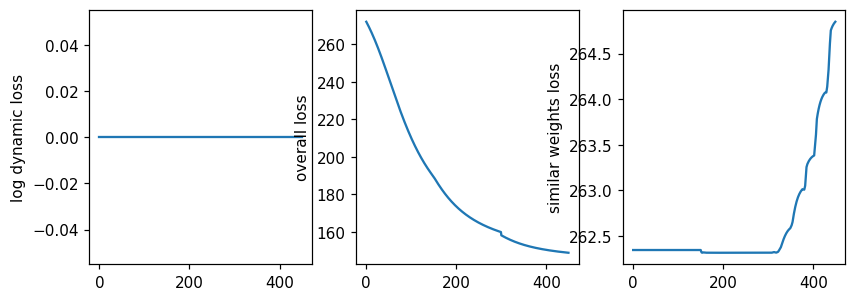

True


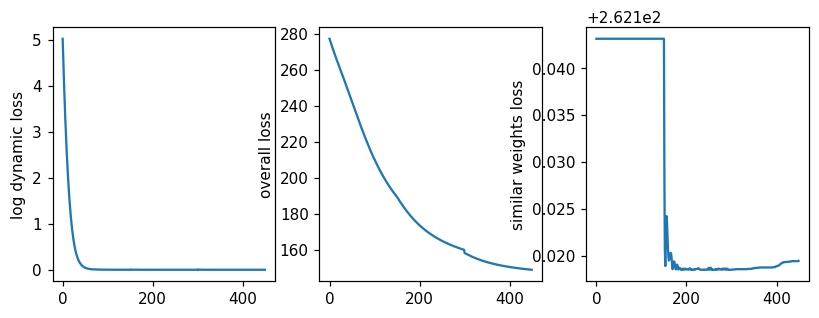

In [75]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    plt.subplot(1, 4, 1)
    plt.plot(model.loss_history_log_dynamic)
    plt.ylabel('log dynamic loss')
    plt.subplot(1, 4, 2)
    plt.plot(model.loss_history)
    plt.ylabel('overall loss')
    plt.subplot(1, 4, 3)
    plt.plot(model.loss_history_sym_weights)
    plt.ylabel('similar weights loss')
    plt.show()

False
True
3
0 out of 288...


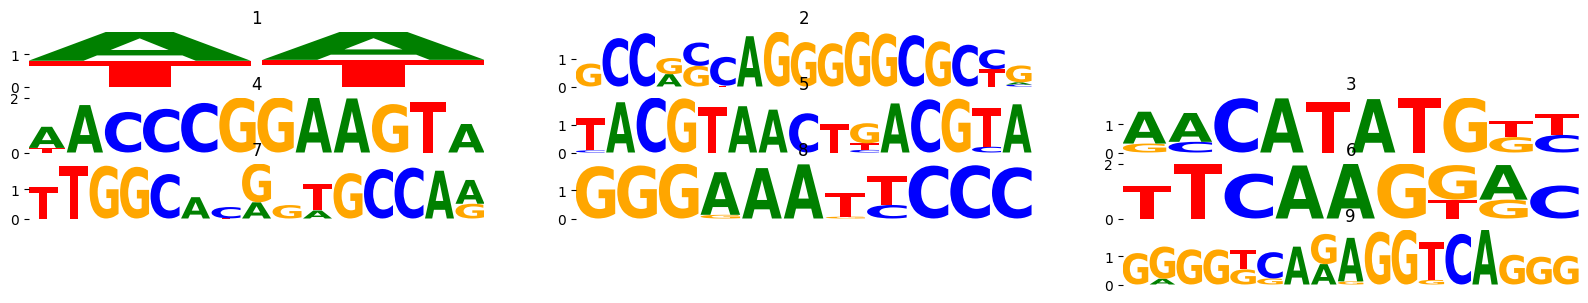

True
True
3
0 out of 288...


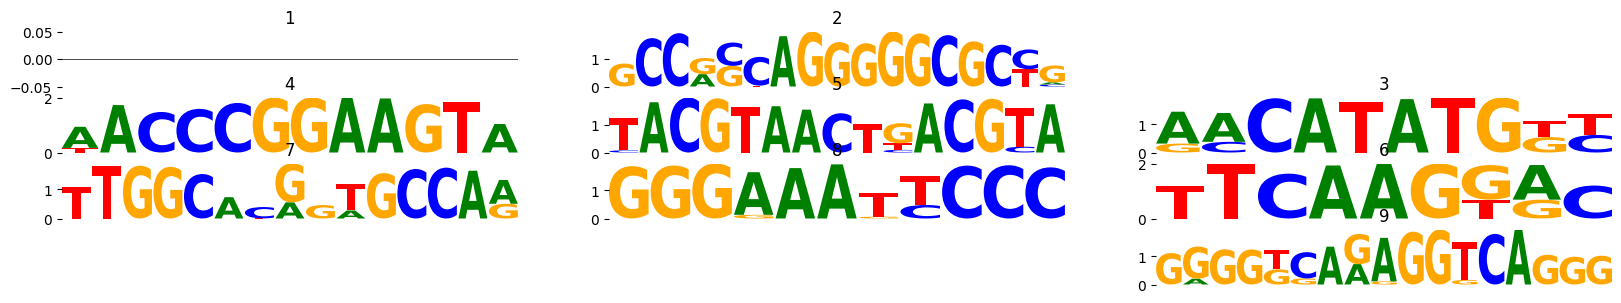

In [76]:

for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.conv(model, n_cols=3, show=True, n_rows=6, stop_at=10)
    plt.show()


True


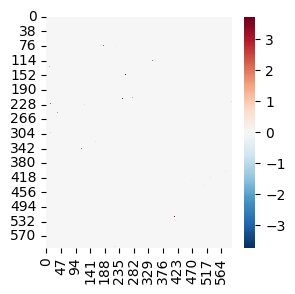

In [77]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.selex_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.selex_module.log_dynamic
    D = model.selex_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns
    mb.pl.set_rcParams({'figure.figsize': [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')
    plt.show()

False
True


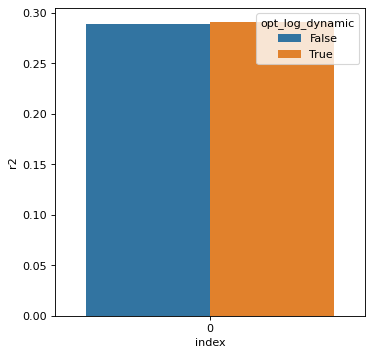

In [78]:
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_all.append(r2)

r2_all = pd.concat(r2_all)
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 80
sns.barplot(data=r2_all, x='index', y='r2', hue='opt_log_dynamic')
plt.show()

In [79]:
model.binding_modes.prob_act

Parameter containing:
tensor([-2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272,
        -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272,
        -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272,
        -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272,
        -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272,
        -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272,
        -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272,
        -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272,
        -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272,
        -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272,
        -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272,
        -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272, -2.8272,
        -2.8272, -

In [80]:

model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2


In [81]:


#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
# mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
# sns.displot(dynamic_score, height=3, aspect=1.2)
# plt.xlabel('dynamic score (normalized)')


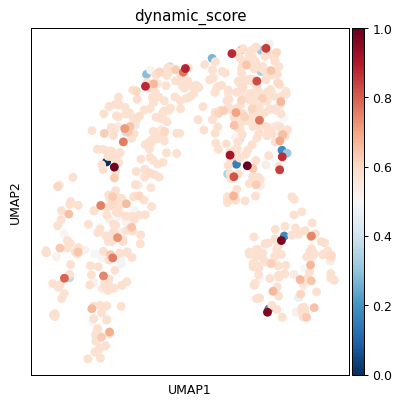

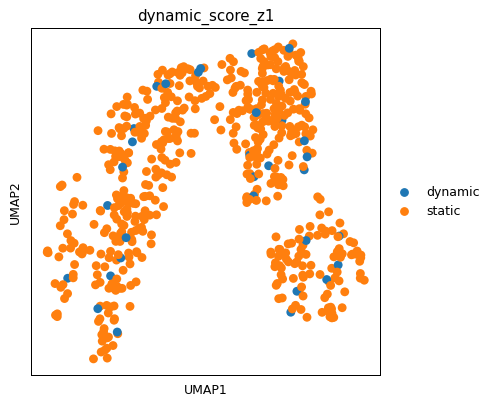

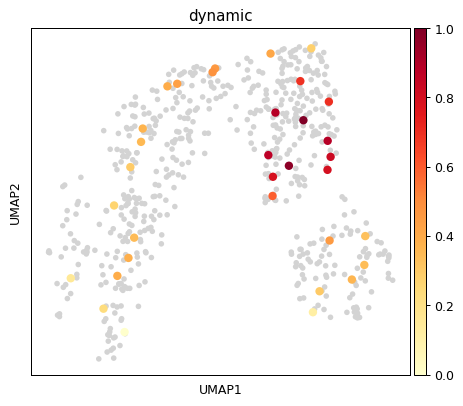

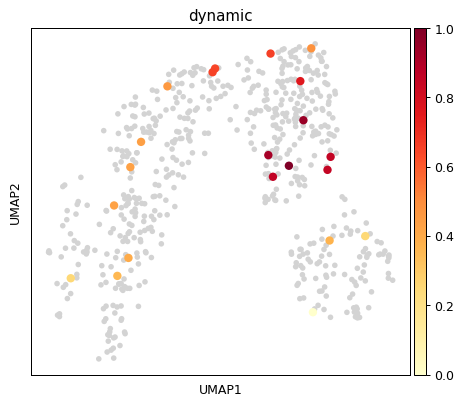

In [82]:


# contributions per newly added kernel
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

False


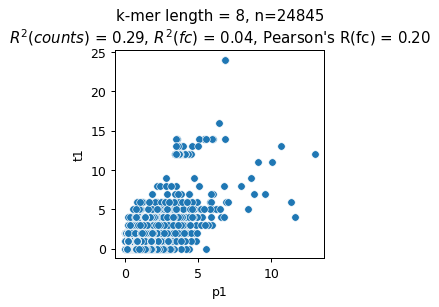

True
3
0 out of 288...
10 out of 288...


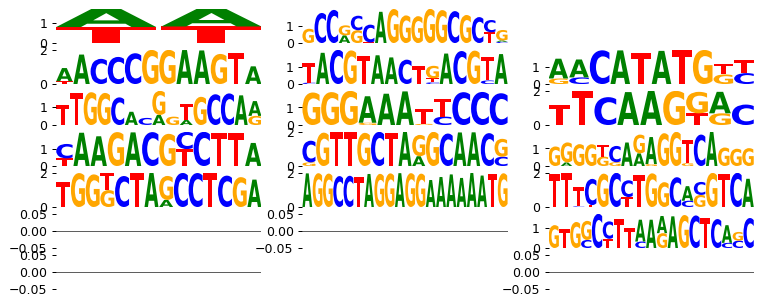

True


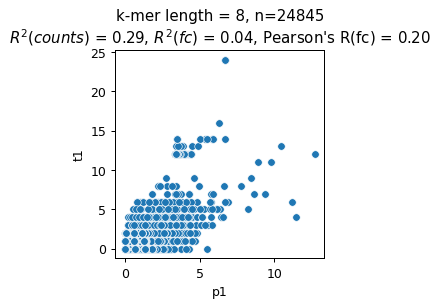

True
3
0 out of 288...
10 out of 288...


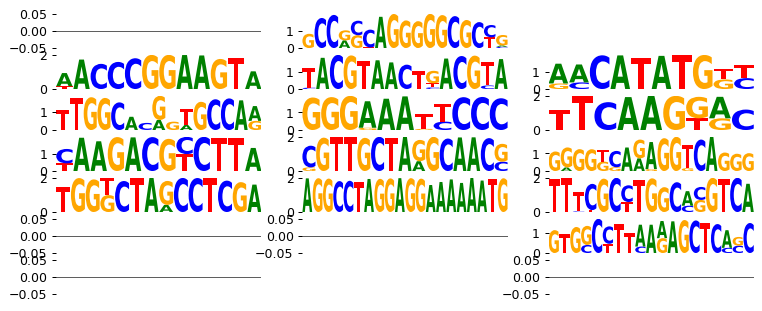

In [83]:
for optimize_log_dynamic in model_by_logdynamic:
    mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
    plt.show()

    mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
    mb.pl.conv(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=12,
               n_cols=3,
               stop_at=20) # n_cols=len(reduced_groups))
    plt.show()


False
True
here...
(900, 600)
42391.996


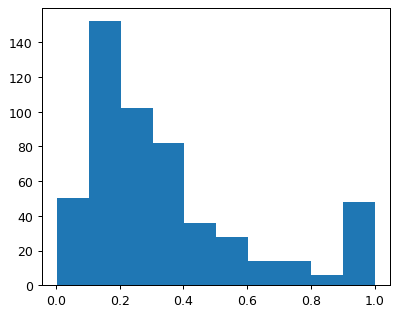

computing velocity graph (using 1/16 cores)


  0%|          | 0/600 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


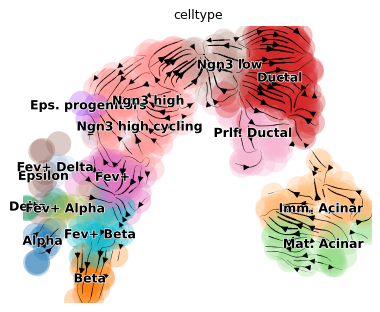

In [84]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]

    umap = ad.obsm['X_umap'].copy()
    umap = np.sort(umap, 0)

    x = umap[:,0]
    y = umap[:,1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                      "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs['scale_countsum'] = model.datatype == 'selex'
        output = model(**inputs, use_conn=False)

        output = output.cpu().detach().numpy()
        print('here...')
        print(output.shape)

        print(output.sum())
        pred.append(output)

    pred = np.concatenate(pred).T
    ad.layers['velocity'] = pred
    ad.layers['counts'] = ad.X

    mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    plt.hist(model.selex_module.conn_sparse.values().detach().cpu().numpy())
    plt.show()

    import scvelo as scv

    sc.pp.neighbors(ad)

    scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    scv.pl.velocity_embedding_stream(ad, color='celltype') #  X_grid='X_umap', V=V)

In [85]:
rna = sc.read_h5ad(rna_path)
rna.shape
rna_sel = rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape
anno = mb.datasets.archetypes_anno()

In [86]:
rna_sel.shape

(600, 14663)

False


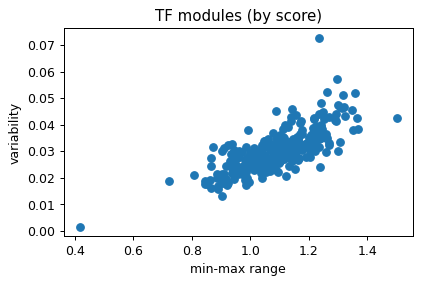

True


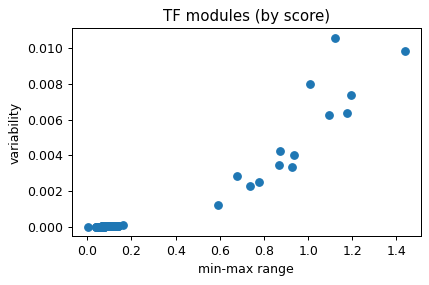

In [87]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

In [88]:
anno.sort_values('Cluster_ID')

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size
61,1,HD/1,homeodomain,LHX6_homeodomain_3,12,0,12,2
72,2,HD/2,homeodomain,ALX3_MA0634.1,26,8,16,186
79,3,HD/3,homeodomain,VENTX_homeodomain_2,21,3,20,1
80,4,HD/4,homeodomain,BARX1_MOUSE.H11MO.0.C,17,5,13,17
81,5,HD/5,homeodomain,BARX1_homeodomain_1,21,2,18,6
...,...,...,...,...,...,...,...,...
163,282,PAX/2,PAX,PAX5_HUMAN.H11MO.0.A,24,4,21,3
161,283,PAX-halfsite,PAX,Pax2_MA0067.1,8,1,7,1
0,284,AHR,bHLH,AHR_HUMAN.H11MO.0.B,9,2,8,3
105,285,KLF/SP/3,C2H2,KLF8_HUMAN.H11MO.0.C,9,0,9,2


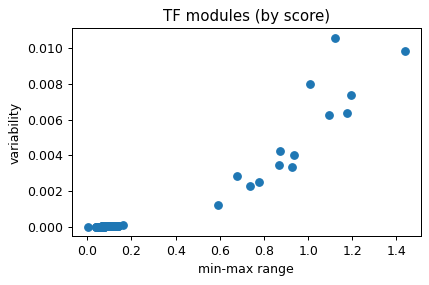

(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,)

In [89]:
from scipy.stats import spearmanr
res = []
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue

    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    log_act.columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

    for c in log_act:
        a = log_act[c]
        b = ad.obs['dynamic_score'].values
        print(a.shape, b.shape)
        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'spearman', 'p_val'])


In [90]:
res.sort_values('spearman', ascending=False)

,opt_log_dynamic,archetype_id,spearman,p_val
8,True,7,0.021743,0.595041
12,True,11,0.017793,0.663583
5,True,4,0.015311,0.708194
10,True,9,0.013637,0.738874
238,True,237,0.010372,0.799858
...,...,...,...,...
14,True,13,-0.045575,0.265018
155,True,154,-0.046938,0.250978
19,True,18,-0.048866,0.232010
2,True,1,-0.055086,0.177805


In [91]:
log_act

,intercept,dinuc_bias,1,2,3,4,5,6,7,8,...,277,278,279,280,281,282,283,284,285,286
AAACCGAAGTGAACAG-1-0,-0.000005,-0.000239,-0.018847,-0.004936,-0.010623,-0.014295,-0.004035,-0.009454,-0.005506,-0.018169,...,-0.000503,-0.000406,-0.000581,-0.000444,-0.000688,-0.000293,-0.000495,-0.000586,-0.000517,-0.000539
AAAGCACCAAGGTACG-1-0,-0.000005,-0.000239,-0.018847,-0.004936,-0.010623,-0.014295,-0.004035,-0.009454,-0.005506,-0.018169,...,-0.000503,-0.000406,-0.000581,-0.000444,-0.000688,-0.000293,-0.000495,-0.000586,-0.000517,-0.000539
AAATGCCTCCATTACT-1-0,-0.000005,-0.000239,-0.018847,-0.004936,-0.010623,-0.014295,-0.004035,-0.009454,-0.005506,-0.018169,...,-0.000503,-0.000406,-0.000581,-0.000444,-0.000688,-0.000293,-0.000495,-0.000586,-0.000517,-0.000539
AACAAGCCACGGTTTA-1-0,0.000435,0.013420,0.939768,0.264280,0.312019,0.549399,0.183323,0.545728,0.297538,0.855754,...,0.046278,0.036455,0.049006,0.036582,0.051583,0.027600,0.032261,0.047806,0.039459,0.040104
AACGGTAAGTTTGAGC-1-0,-0.000005,-0.000239,-0.018847,-0.004936,-0.010623,-0.014295,-0.004035,-0.009454,-0.005506,-0.018169,...,-0.000503,-0.000406,-0.000581,-0.000444,-0.000688,-0.000293,-0.000495,-0.000586,-0.000517,-0.000539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGTGAGTTTGGTTC-1-1,-0.000014,-0.000433,0.036897,-0.019543,-0.017847,-0.024935,-0.013421,-0.013859,-0.029977,-0.065594,...,-0.001659,-0.001347,-0.001701,-0.000934,-0.001086,-0.000849,-0.000938,-0.001989,-0.000940,-0.001425
TTTCCGGGTAATCGTG-1-1,-0.000005,-0.000239,-0.018847,-0.004936,-0.010623,-0.014295,-0.004035,-0.009454,-0.005506,-0.018169,...,-0.000503,-0.000406,-0.000581,-0.000444,-0.000688,-0.000293,-0.000495,-0.000586,-0.000517,-0.000539
TTTCTCACAACGTGCT-1-1,-0.000011,-0.001250,0.225781,-0.017007,-0.031921,-0.048271,-0.017166,-0.000097,-0.013391,0.058443,...,-0.001036,-0.000815,-0.001097,-0.000916,-0.001623,-0.000821,-0.001260,-0.000668,-0.001118,-0.001389
TTTGCATTCCTGGTCT-1-1,-0.000002,-0.000081,-0.014483,0.000377,-0.003745,-0.017196,-0.002011,-0.009811,-0.014864,-0.022255,...,-0.000320,-0.000126,-0.000104,-0.000194,-0.000294,-0.000046,-0.000085,-0.000495,-0.000153,-0.000097


In [92]:
res = pd.DataFrame(pd.concat([delta, var], axis=1))
res['name'] = ['intercept', 'dinuc_bias'] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
res['archetypes_name'] = res['name'].map(anno.set_index('Cluster_ID')['Name'])
res['archetypes_seed'] = res['name'].map(anno.set_index('Cluster_ID')['Seed_motif'])
res = res.sort_values(0, ascending=0)
res

,0,1,name,archetypes_name,archetypes_seed
1,1.437000,9.818841e-03,1,HD/1,LHX6_homeodomain_3
8,1.194844,7.395296e-03,8,HD/8,ALX1_HUMAN.H11MO.0.B
4,1.174854,6.388893e-03,4,HD/4,BARX1_MOUSE.H11MO.0.C
13,1.122583,1.057599e-02,13,NFY,Dux_MA0611.1
12,1.094952,6.228411e-03,12,HD/12,PBX1_HUMAN.H11MO.0.A
...,...,...,...,...,...
75,0.050162,8.468530e-06,75,ZNF257,ZN257_HUMAN.H11MO.0.C
222,0.041070,7.514655e-06,222,ZNF784,ZNF784_C2H2_1
18,0.041042,4.973660e-06,18,HD/13,CDX1_HUMAN.H11MO.0.C
237,0.039438,8.882759e-06,237,ZBED1,ZBED1_MA0749.1


<AxesSubplot: xlabel='0', ylabel='archetypes_name'>

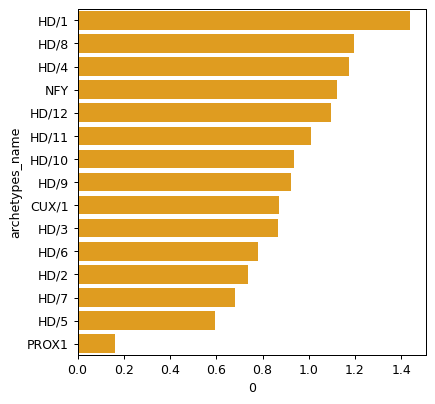

In [93]:
rcParams['figure.figsize'] = 5, 5
sns.barplot(data=res.head(15), x=0, y='archetypes_name', color='orange')

In [94]:
res.head(20)

,0,1,name,archetypes_name,archetypes_seed
1,1.437000,0.009819,1,HD/1,LHX6_homeodomain_3
8,1.194844,0.007395,8,HD/8,ALX1_HUMAN.H11MO.0.B
4,1.174854,0.006389,4,HD/4,BARX1_MOUSE.H11MO.0.C
13,1.122583,0.010576,13,NFY,Dux_MA0611.1
12,1.094952,0.006228,12,HD/12,PBX1_HUMAN.H11MO.0.A
11,1.009891,0.007980,11,HD/11,MEOX2_homeodomain_3
10,0.937757,0.004003,10,HD/10,HNF1A_HUMAN.H11MO.0.C
9,0.924971,0.003342,9,HD/9,Lhx3_MA0135.1
14,0.871059,0.004219,14,CUX/1,CUX1_CUT_3
3,0.868683,0.003437,3,HD/3,VENTX_homeodomain_2


In [95]:
model.binding_modes

BindingModesSimple(
  (conv_mono): ModuleList(
    (0): None
    (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
    (2): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
    (3): Conv2d(1, 1, kernel_size=(4, 18), stride=(1, 1), bias=False)
    (4): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
    (5): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
    (6): Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)
    (7): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
    (8): Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
    (9): Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
    (10): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
    (11): Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)
    (12): Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
    (13): Conv2d(1, 1, kernel_size=(4, 8), stride=(1, 1), bias=False)
    (14): Conv2d(1, 1, kernel

True
1
0 out of 288...
10 out of 288...


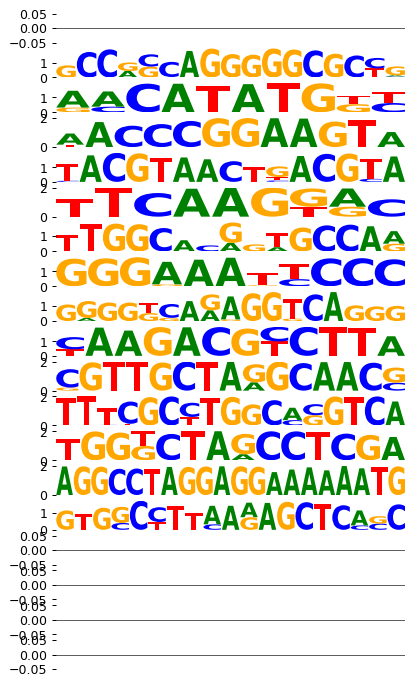

In [96]:
mb.pl.set_rcParams({'figure.figsize': [5, 20], 'figure.dpi': 90})
mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
           # n_rows=len(res.head(20).index),

True
1
0 out of 288...
10 out of 288...


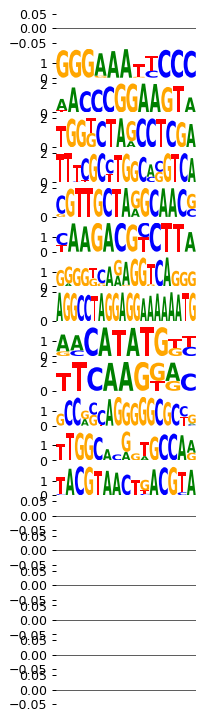

<Figure size 180x1800 with 0 Axes>

In [97]:
mb.pl.set_rcParams({'figure.figsize': [2, 20], 'figure.dpi': 90})
mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40,
           # n_rows=len(res.head(20).index),
           n_cols=1, order=res.head(20).index) # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [98]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 6.349336


In [99]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')


In [100]:
rna_sel.obsm['X_umap'] = ad.obsm['X_umap']

In [101]:
def find_varname(ad, k):
    return ad.var_names[ad.var_names.str.upper().str.contains(k.upper())]

In [102]:
from scipy.stats import spearmanr

In [103]:

all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap='Reds')

res = []
print(len(all_targets))
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    log_act = ad.obsm['log_activities'][k].values
    for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
        # print(ki)
        if ki % 10 == 0:
            print(ki)
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        next_targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            # print(name, target)
            for t in target:
                next_targets.add(t)

        # for t in all_targets:
        for t in set(all_targets).intersection(next_targets):
            gex = rna_sel.X[:,rna_sel.var_names == t]
            assert gex.shape[1] == 1
            gex = gex.A.flatten()
            # print(log_act.shape, gex.shape)
            # print(t, pearsonr(log_act, gex))
            res.append([optimize_log_dynamic, k, t, t in next_targets] +
                       list(spearmanr(log_act, gex)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

False
True
3828
False
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
True
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


In [104]:
res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())

In [105]:
res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])

In [106]:
from statsmodels.stats.multitest import fdrcorrection
res['p_adj'] = fdrcorrection(res['p_val'])[1]
res[res['p_adj'] < 0.1]

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
2,False,2,Gen1,True,0.154097,1.510211e-04,HD/2,0.030184
10,False,2,Mien1,True,-0.172409,2.174627e-05,HD/2,0.006795
35,False,7,Gen1,True,0.154097,1.510211e-04,HD/7,0.030184
40,False,7,Mien1,True,-0.172409,2.174627e-05,HD/7,0.006795
115,False,40,Nr5a2,True,0.134805,9.320650e-04,NR/11,0.089350
...,...,...,...,...,...,...,...,...
4315,False,248,Arhgap11a,True,0.211484,1.706702e-07,NR/20,0.000150
4374,False,262,Zbtb7c,True,-0.146914,3.053107e-04,GLI,0.049720
4384,False,265,Ctcf,True,0.134614,9.479594e-04,CTCF,0.089350
6977,True,70,Tpk1,True,-0.132686,1.122948e-03,TBX/1,0.096061


In [107]:
res['k'] = res['gene_name'] + '_' + res['archetype_id'].astype(str)
df2 = res.pivot('k', 'opt_log_dynamic', 'spearman')
df2['matched'] = res.pivot('k', 'opt_log_dynamic', 'matched')[False]

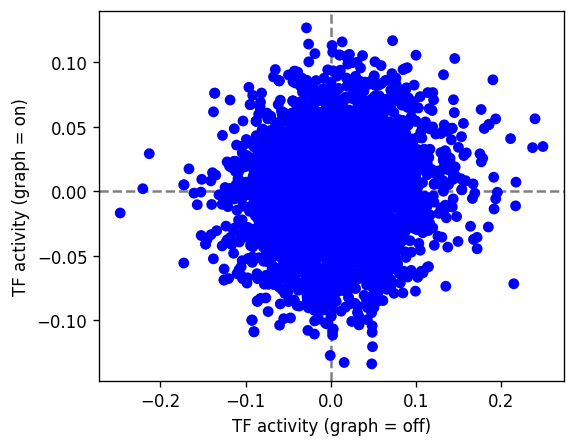

In [108]:
mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 120})
df2 = df2.sort_values('matched', ascending=True)
plt.scatter(df2[False], df2[True],
            color=np.where(df2['matched'], 'blue', 'gray'),
            s=np.where(df2['matched'], 30, 5))
plt.xlabel('TF activity (graph = off)')
plt.ylabel('TF activity (graph = on)')
plt.axhline(0, color='gray', ls='--', zorder=0)
plt.axvline(0, color='gray', ls='--', zorder=0)


In [109]:
df2[df2['matched'] == True].sort_values(True, ascending=False)

opt_log_dynamic,False,True,matched
k,,,
Smarcad1_248,-0.028380,0.126727,True
Trmt13_70,0.072816,0.116797,True
Tox2_70,0.013566,0.115874,True
Mlxip_58,-0.025890,0.114155,True
Agtr1a_70,0.001747,0.113100,True
...,...,...,...
Stox2_70,0.049185,-0.120437,True
Tmem65_70,-0.000444,-0.127254,True
Tpk1_70,0.015954,-0.132686,True


False


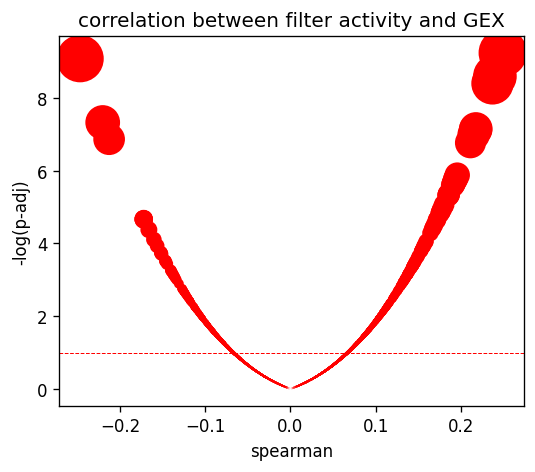

True


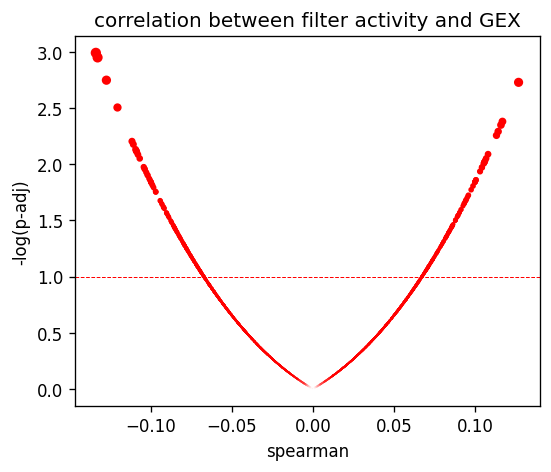

In [110]:
for optimize_log_dynamic, grp in res.groupby('opt_log_dynamic'):
    print(optimize_log_dynamic)
    grp['minus_log10_pval'] = -np.log10(grp['p_val'])
    grp = grp.sort_values('matched')
    plt.scatter(grp['spearman'], grp['minus_log10_pval'],
                s=np.power(grp['minus_log10_pval'], 3), color=np.where(grp['matched'], 'red', 'blue'))
    plt.ylabel('-log(p-adj)')
    plt.xlabel('spearman')
    plt.title('correlation between filter activity and GEX')
    plt.axhline(1, ls='--', color='red', lw=0.6)
    plt.show()

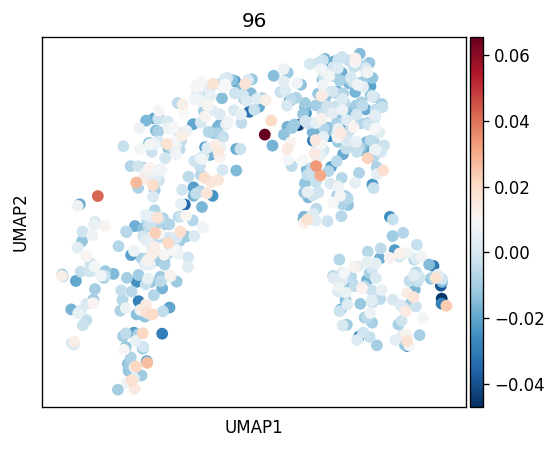

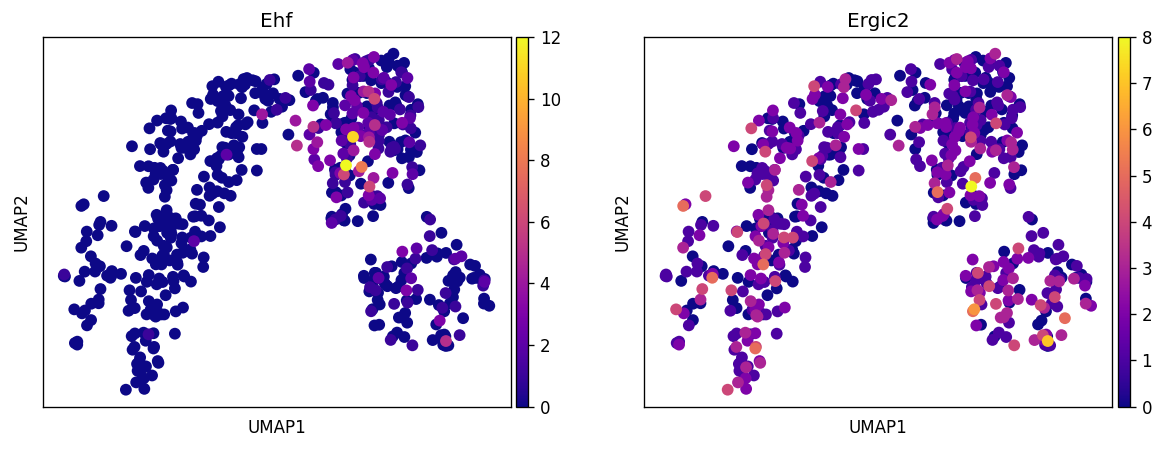

In [111]:
sc.pl.umap(ad, color=[96], cmap='RdBu_r')
sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

In [112]:
res[res['p_val'] < 0.1]

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
2,False,2,Gen1,True,0.154097,0.000151,HD/2,0.030184,Gen1_2
10,False,2,Mien1,True,-0.172409,0.000022,HD/2,0.006795,Mien1_2
13,False,2,Fen1,True,0.087540,0.032038,HD/2,0.493427,Fen1_2
18,False,2,Arxes2,True,-0.078467,0.054732,HD/2,0.581690,Arxes2_2
19,False,2,Tsen15,True,0.085812,0.035602,HD/2,0.507316,Tsen15_2
...,...,...,...,...,...,...,...,...,...
8707,True,248,Ermard,True,0.072471,0.076096,NR/20,0.635872,Ermard_248
8711,True,248,Narf,True,-0.073832,0.070732,NR/20,0.624434,Narf_248
8713,True,248,Arfgef2,True,-0.070181,0.085868,NR/20,0.646507,Arfgef2_248
8745,True,257,Trp53,True,-0.068231,0.094966,P53-like/1,0.661346,Trp53_257


In [113]:
pval_thr = 1e-5
sel_genes = set(list(res[res['p_adj'] < pval_thr]['gene_name']))

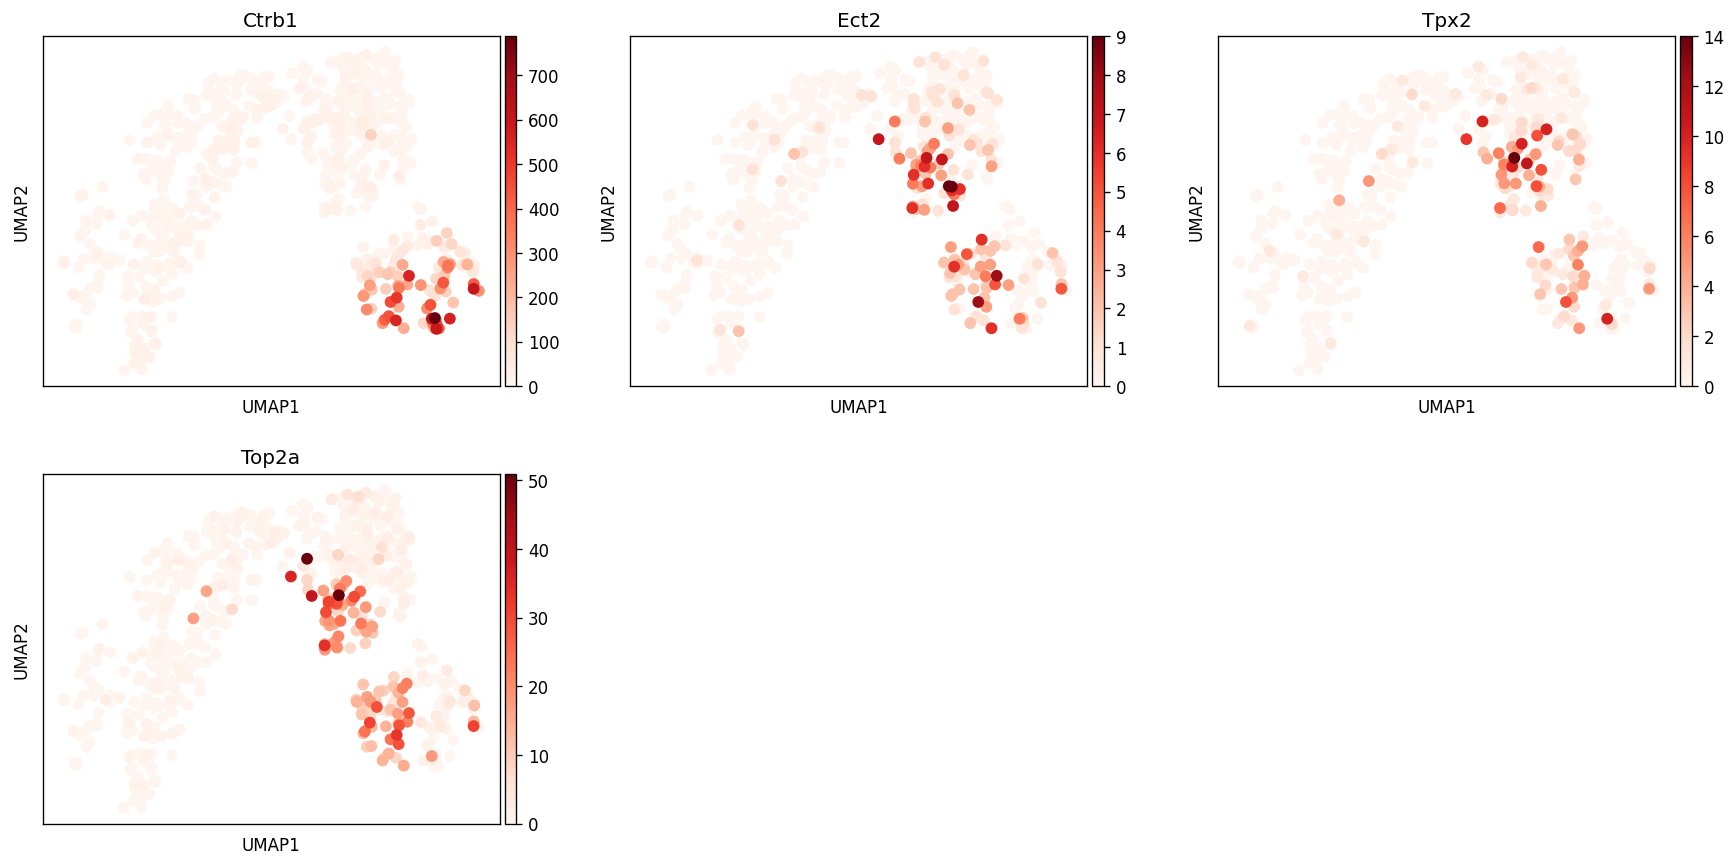

In [114]:
sc.pl.umap(rna_sel, color=sel_genes,
           cmap='Reds', ncols=3)


In [115]:
import anndata
ad_act = anndata.AnnData(ad.obsm['log_activities'])
ad_act.obsm['X_umap'] = ad.obsm['X_umap']
ad_act.obs = ad.obs

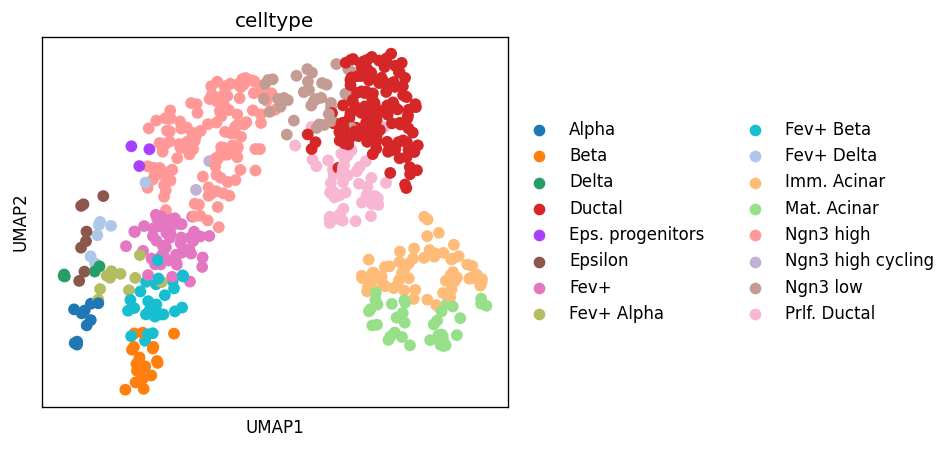

In [116]:
sc.pl.umap(ad_act, color='celltype')


Rank genes groups using the annotation

In [117]:
sc.tl.rank_genes_groups(ad_act, 'celltype')
rkg_df = []
for ct in ad_act.obs['celltype'].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2['celltype'] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df['module_name'] = rkg_df['names'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
rkg_df['module_name'] = np.where(~pd.isnull(rkg_df['module_name']), rkg_df['module_name'], rkg_df['names'])
rkg_df.head()

Ngn3 high
Fev+ Delta
Ductal
Ngn3 low
Prlf. Ductal
Imm. Acinar
Alpha
Fev+ Beta
Epsilon
Fev+ Alpha
Fev+
Ngn3 high cycling
Delta
Beta
Eps. progenitors
Mat. Acinar


,names,scores,logfoldchanges,pvals,pvals_adj,celltype,module_name
0,2,0.544601,-2.907608,0.586718,0.999883,Ngn3 high,HD/2
1,81,0.359431,NaN,0.719662,0.999883,Ngn3 high,ZNF435
2,38,0.353866,NaN,0.723814,0.999883,Ngn3 high,NR/9
3,43,0.335353,NaN,0.737670,0.999883,Ngn3 high,NR/14
4,205,0.314433,NaN,0.753523,0.999883,Ngn3 high,HD/24


Get top modules

In [118]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index('names')['module_name'].to_dict())

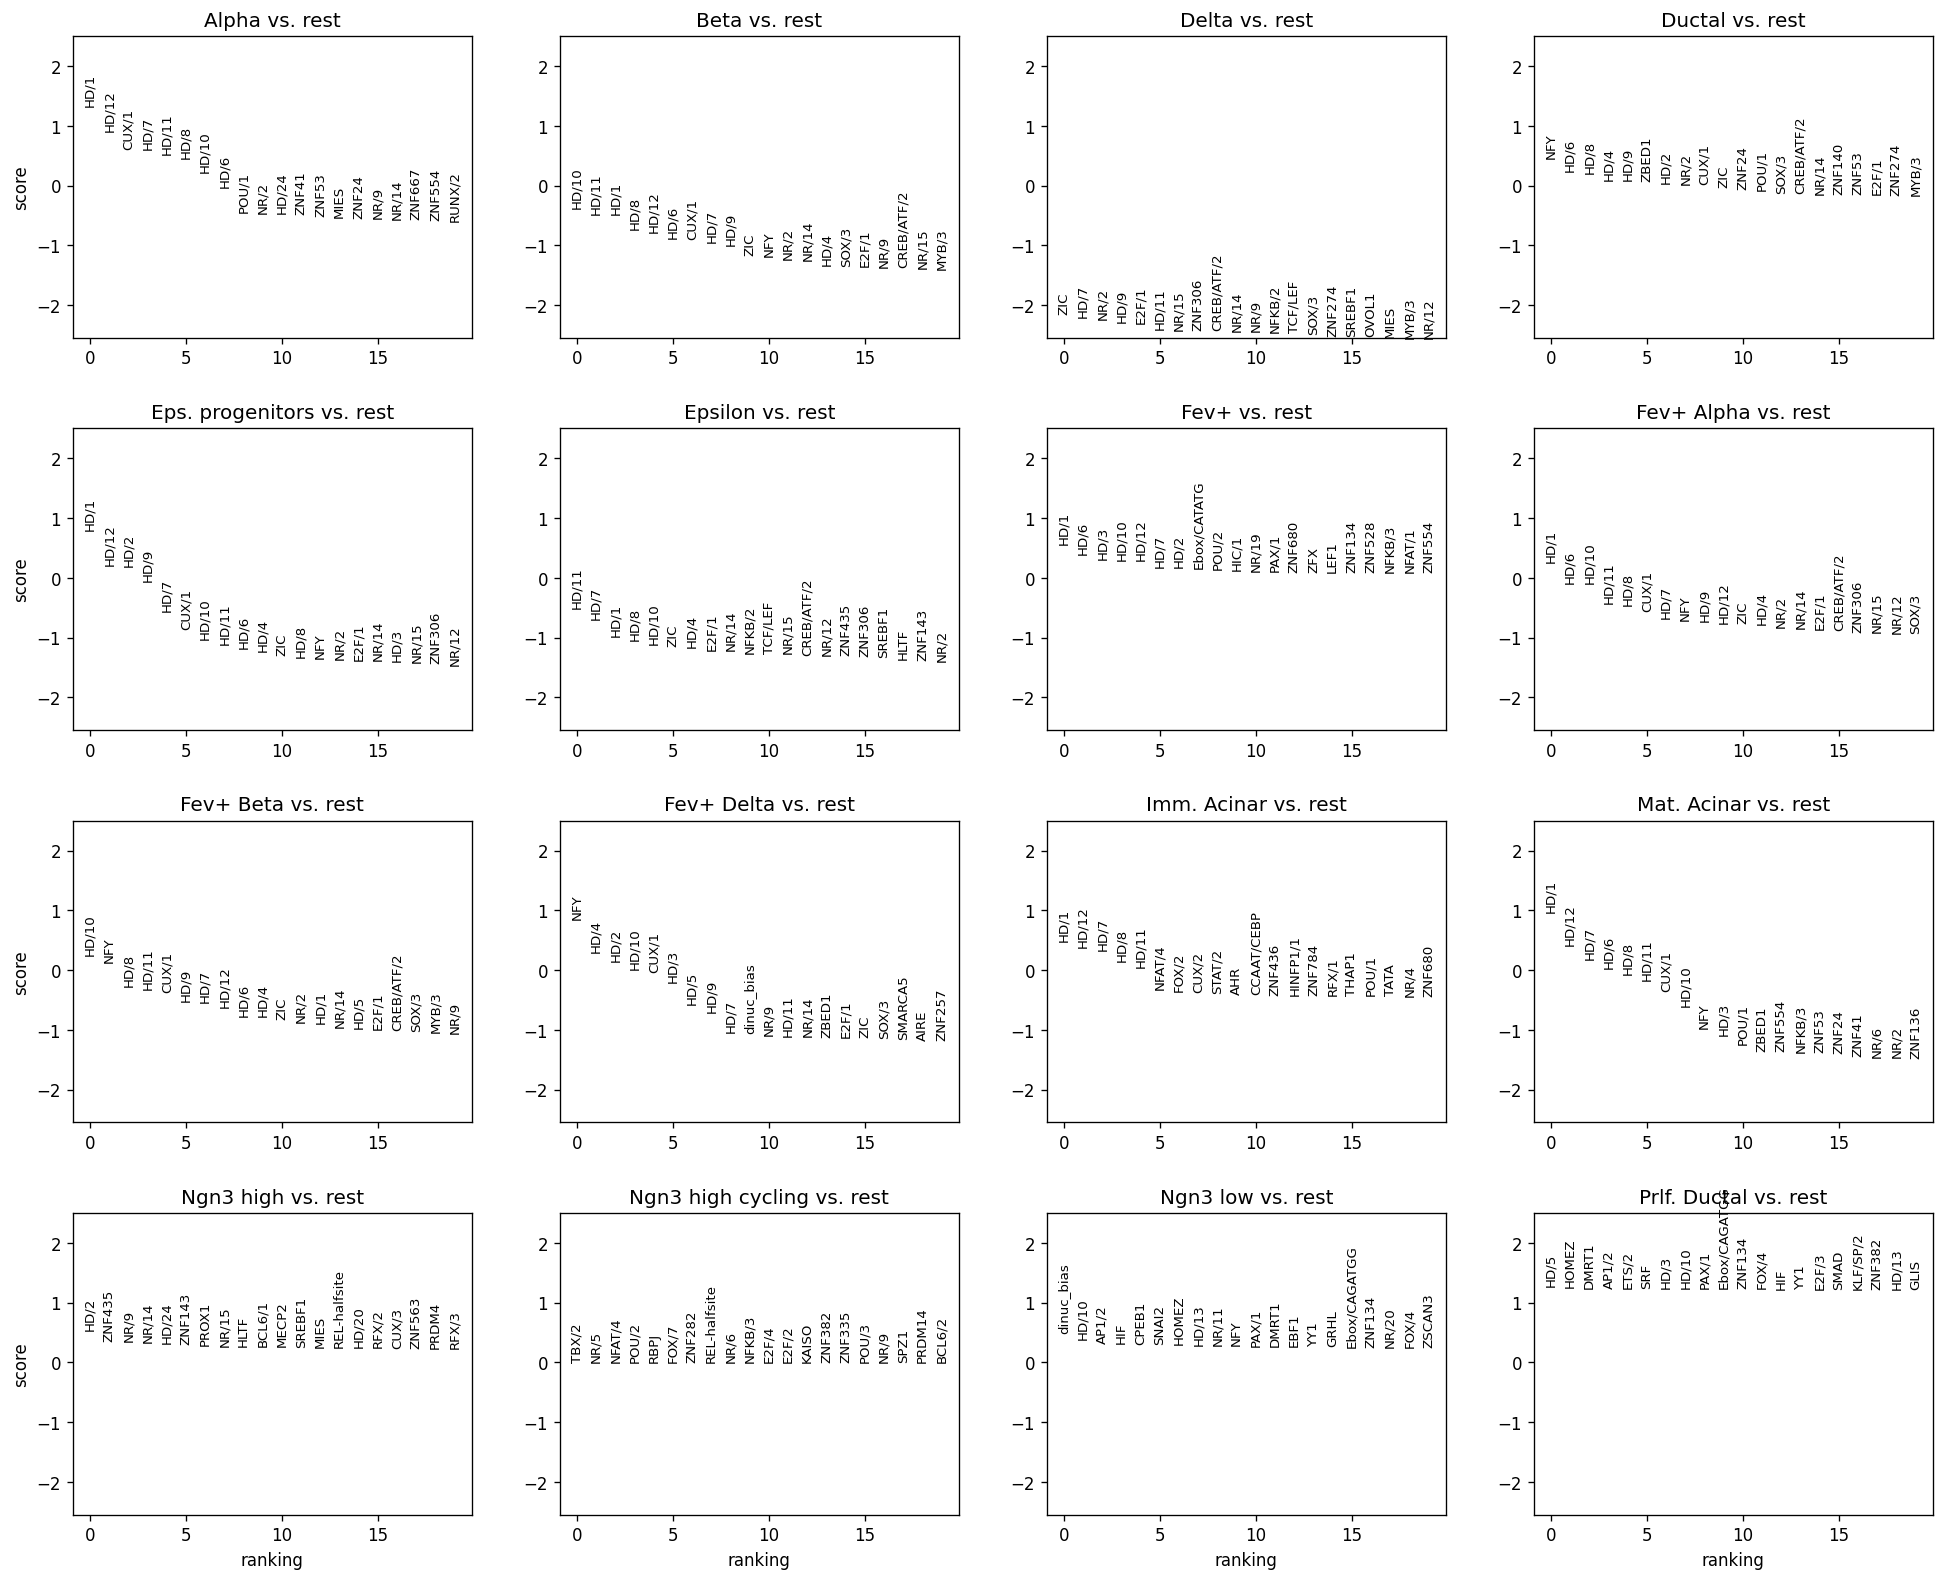

In [119]:
sc.tl.rank_genes_groups(ad_act, 'celltype')
sc.pl.rank_genes_groups(ad_act)


In [120]:
len(set(res[(res['p_adj'] < 1e-5)]['k']))

4

In [121]:
set(res[(res['p_adj'] < 1e-5)]['k'])

{'Ctrb1_70', 'Ect2_70', 'Top2a_70', 'Tpx2_70'}

In [122]:
res[res['module_name'].str.contains('HD')].sort_values('p_adj')

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
10,False,2,Mien1,True,-0.172409,0.000022,HD/2,0.006795,Mien1_2
40,False,7,Mien1,True,-0.172409,0.000022,HD/7,0.006795,Mien1_7
2,False,2,Gen1,True,0.154097,0.000151,HD/2,0.030184,Gen1_2
35,False,7,Gen1,True,0.154097,0.000151,HD/7,0.030184,Gen1_7
65,False,19,Meis1,True,0.112268,0.005906,HD/14,0.254624,Meis1_19
...,...,...,...,...,...,...,...,...,...
11,False,2,Dusp7,True,0.000847,0.983491,HD/2,0.999160,Dusp7_2
4432,True,7,Gen1,True,0.001231,0.975994,HD/7,0.999160,Gen1_7
4399,True,2,Gen1,True,0.001231,0.975994,HD/2,0.999160,Gen1_2
4430,True,7,Men1,True,0.000171,0.996658,HD/7,0.999992,Men1_7


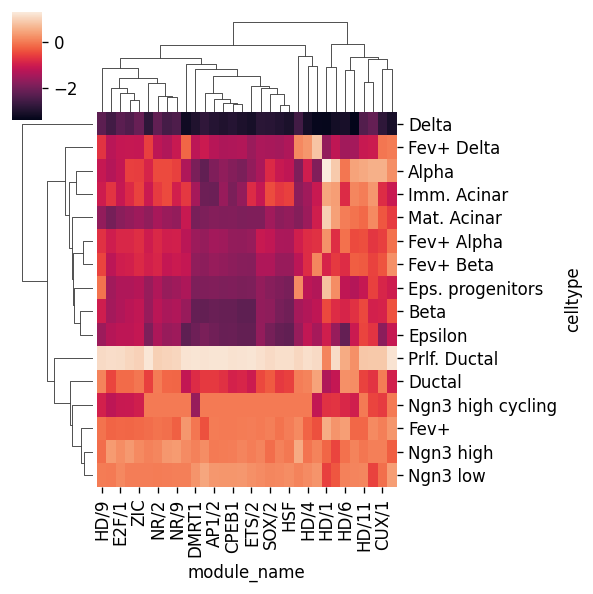

In [123]:
mod_names_best = set(rkg_df.sort_values('scores', ascending=False).groupby('celltype').head(5)['module_name'])
sns.clustermap(rkg_df[rkg_df['module_name'].isin(mod_names_best)].pivot('celltype', 'module_name', 'scores'), figsize=[5, 5])


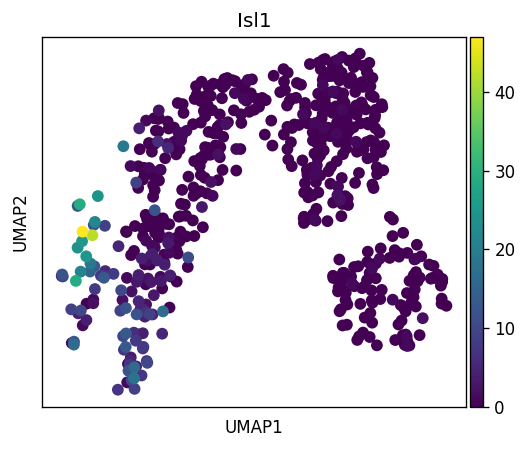

In [124]:
sc.pl.umap(rna_sel, color='Isl1')


In [125]:
rna_sel['Ehf']

KeyError: 'Ehf'

In [ ]:
from matplotlib import rcParams, cm
cmap = cm.get_cmap('YlOrRd')
cmap.set_over('black')
cmap.set_under('lightgray')

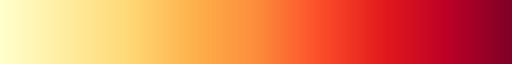

In [ ]:
cmap

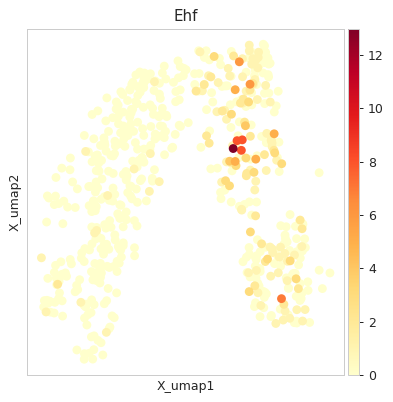

In [ ]:
sc.pl.embedding(rna_sel, basis='X_umap', color='Ehf', color_map=cmap)
